### Colab setup

In [1]:
USE_COLAB = True  # True if the notebook is running in colab and not in kaggle

In [2]:
!pip install -q resnest

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 69.9 MB/s eta 0:00:00


In [3]:
if USE_COLAB:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
if USE_COLAB:
  import json

  !pip install --upgrade --force-reinstall --no-deps  kaggle > /dev/null
  !mkdir /root/.kaggle
  !touch /root/.kaggle/kaggle.json

  api_token = {"username":"danaramati","key":"fb9d2040818aec3c764ebeb2b0910fa4"}
  with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

  !chmod 600 /root/.kaggle/kaggle.json


In [5]:
%%time

import os
if not os.path.exists("/content/datasets/audio_images"):
  !mkdir datasets
  !kaggle datasets download -d kneroma/kkiller-birdclef-models-public
  !kaggle datasets download -d danaramati/birdclef-mels-2022
  !unzip /content/birdclef-mels-2022 -d datasets
  !unzip /content/kkiller-birdclef-models-public -d datasets

Streaming output truncated to the last 5000 lines.
  inflating: datasets/audio_images/normoc/XC608255.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608256.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608257.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608258.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608259.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608447.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608450.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608452.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608453.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608485.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608486.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608487.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608489.ogg.npy  
  inflating: datasets/audio_images/normoc/XC608496.ogg.npy  
  inflating: datasets/audio_images/normoc/XC610095.ogg.npy  
  inflating: datasets/audio_images

In [6]:
###############
### IMPORTS ###
###############
import gc
import re
import json
import time
import joblib
import librosa
from pathlib import Path
from tqdm.notebook import tqdm

import numpy as np
import pandas as pd
from  ast import literal_eval

import torch
from torch import nn
import resnest
from resnest.torch import resnest50
from  sklearn.model_selection import StratifiedKFold
from sklearn.metrics import label_ranking_average_precision_score

In [7]:
#####################
### Configuration ###
#####################

NUM_CLASSES_2021 = 397
NUM_CLASSES = 152
SR = 32_000
DURATION = 7

MAX_READ_SAMPLES = 6 # num samples from each recording. max-10, can be increased with colab

TRAIN_BATCH_SIZE = 100
TRAIN_NUM_WORKERS = 2
SEED = 261

VAL_BATCH_SIZE = 128
VAL_NUM_WORKERS = 2
SECONDARY_LABEL_TRESH = 0.225

MODEL_ROOT = Path('/content/drive/MyDrive') if USE_COLAB else Path(".")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", DEVICE)

Device: cuda


In [8]:
##################
### DATA PATHS ###
##################
if not USE_COLAB:
  DATA_ROOT = Path("../input/birdclef-mels-2022")
  TRAIN_AUDIO_22 = '/kaggle/input/birdclef-2022/train_audio/'
  PRETRAINED_WEIGHTS = '/kaggle/input/kkiller-birdclef-models-public/birdclef_resnest50_fold0_epoch_10_f1_val_06471_20210417161101.pth'

  OUTPUT_DIR = '/kaggle/working/'

else:
  DATA_ROOT = Path("/content/datasets")
  TRAIN_AUDIO_22 = DATA_ROOT / "audio_images"
  #TRAIN_AUDIO_22 = '/content/content/kaggle/working/audio_images'
  PRETRAINED_WEIGHTS = DATA_ROOT / 'birdclef_resnest50_fold0_epoch_10_f1_val_06471_20210417161101.pth'
  OUTPUT_DIR = '/content/drive/MyDrive'

METADATA_PATH = DATA_ROOT / "rich_train_metadata.csv"
TRAIN_LABEL_PATH = DATA_ROOT / "LABEL_IDS.json"

### load metadata and data

In [9]:
def split_by_column(df: pd.DataFrame, key_column: str, n_folds: int):
  fold_index_by_key = {}
  fold_sizes = [0 for i in range(n_folds)]

  for key, key_df in sorted(df.groupby(key_column), key=lambda tup: len(tup[1]), reverse=True):
    fold_num = np.argmin(fold_sizes)
    fold_sizes[fold_num] += len(key_df)
    fold_index_by_key[key] = fold_num

  df_with_fold = df.copy()
  df_with_fold['fold'] = df_with_fold.apply(lambda row: fold_index_by_key[row[key_column]], axis=1)
  return df_with_fold

def get_training_metadata(meta_path=METADATA_PATH, labels_path=TRAIN_LABEL_PATH, n_splits=5, seed=SEED):
    df = None
    label_ids = {}

    df = pd.read_csv(str(meta_path), index_col=0)
    df = df[df["rating"] >= 2]
    df["impath"] = df.apply(lambda row: meta_path.parent/"audio_images/{}.npy".format(row.filename), axis=1)
    df["secondary_labels"] = df["secondary_labels"].apply(literal_eval)
    df["is_aug"] = False

    repeats = 1 + ((500 - df["primary_label"].value_counts()) // 250)
    df["aug_count"] = df.apply(lambda row: repeats[row.primary_label], axis=1)

    df = df.loc[df.index.repeat(df["aug_count"])]
    duplicated_indices = df.index.duplicated(keep='first')
    df.loc[duplicated_indices, "is_aug"] = True
    df = df.reset_index(drop=True)

    # folds by authors
    df = split_by_column(df, key_column="author", n_folds=5)

    with open(str(labels_path)) as f:
        label_ids.update(json.load(f))

    return label_ids, df


def load_data(df):
    def load_row(row):
        return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES]

    pool = joblib.Parallel(4)
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    return res

In [10]:
LABEL_IDS, meta = get_training_metadata()

print(meta.shape)

(21289, 22)


In [ ]:
meta.tail()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,...,filename,label_id,filepath,frames,sr,duration,fold,impath,is_aug,aug_count
21284,zebdov,[],"['adult', 'call', 'sex uncertain']",1.4347,103.7043,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,...,zebdov/XC665873.ogg,151,../input/birdclef-2022/train_audio/zebdov/XC66...,1458432,32000,45.576,0,/content/datasets/audio_images/zebdov/XC665873...,True,2
21285,zebdov,[],['song'],3.3508,101.2451,Geopelia striata,Zebra Dove,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,2.5,...,zebdov/XC666194.ogg,151,../input/birdclef-2022/train_audio/zebdov/XC66...,689632,32000,21.551,2,/content/datasets/audio_images/zebdov/XC666194...,False,2
21286,zebdov,[],['song'],3.3508,101.2451,Geopelia striata,Zebra Dove,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,2.5,...,zebdov/XC666194.ogg,151,../input/birdclef-2022/train_audio/zebdov/XC66...,689632,32000,21.551,2,/content/datasets/audio_images/zebdov/XC666194...,True,2
21287,zebdov,[],['song'],3.3508,101.2451,Geopelia striata,Zebra Dove,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,2.5,...,zebdov/XC666195.ogg,151,../input/birdclef-2022/train_audio/zebdov/XC66...,1262208,32000,39.444,2,/content/datasets/audio_images/zebdov/XC666195...,False,2
21288,zebdov,[],['song'],3.3508,101.2451,Geopelia striata,Zebra Dove,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,2.5,...,zebdov/XC666195.ogg,151,../input/birdclef-2022/train_audio/zebdov/XC66...,1262208,32000,39.444,2,/content/datasets/audio_images/zebdov/XC666195...,True,2


In [ ]:
meta["label_id"].min(), meta["label_id"].max()

(0, 151)

### Create model from pretrained 2021 weights

In [12]:
def load_model(checkpoint_path=PRETRAINED_WEIGHTS, num_classes=NUM_CLASSES):
    net = resnest50(pretrained=False)
    num_features = net.fc.in_features
    net.fc = nn.Linear(num_features, NUM_CLASSES_2021)
    dummy_device = torch.device("cpu")
    d = torch.load(checkpoint_path, map_location=dummy_device)

    for key in list(d.keys()):
        d[key.replace("model.", "")] = d.pop(key)
    net.load_state_dict(d)
    net.fc = nn.Linear(num_features, num_classes)
    net = net.to(DEVICE)
    net = net.eval()
    return net

### Spectogram Augmentation

In [13]:
import random

def duplicate_last_to_match_shape(array1, array2):
    # Determine the larger and smaller array by their first dimension size
    if array1.shape[0] < array2.shape[0]:
        smaller_array, larger_array = array1, array2
    else:
        smaller_array, larger_array = array2, array1

    # Calculate the difference in the first dimension
    diff = larger_array.shape[0] - smaller_array.shape[0]

    # If there is a difference, duplicate the last item of the smaller array
    if diff > 0:
        # Repeat the last item along the first dimension
        last_item = np.expand_dims(smaller_array[-1], axis=0)
        duplicates = np.repeat(last_item, diff, axis=0)

        # Concatenate the duplicates to the smaller array
        smaller_array = np.concatenate([smaller_array, duplicates], axis=0)

    return (smaller_array, larger_array) if array1.shape[0] < array2.shape[0] else (larger_array, smaller_array)

# Apply Mixup augmentation to two samples and their labels.
def mixup(data1, data2, label1, label2, alpha=0.2):
    # Sample lambda from the beta distribution
    lam = np.random.beta(alpha, alpha)

    data1, data2 = duplicate_last_to_match_shape(data1, data2)

    # Mix the data and labels
    mixed_data = lam * data1 + (1 - lam) * data2
    mixed_label = lam * label1 + (1 - lam) * label2

    return mixed_data, mixed_label


# metod from Google Brain paper, shich add vertical / horizontal lines to spectorgam
def spec_augment(spec: np.ndarray, num_mask=2,
                 freq_masking_max_percentage=0.15, time_masking_max_percentage=0.3):

    spec = spec.copy()
    for i in range(num_mask):
        #all_frames_num, all_freqs_num = spec[0].shape
        all_frames_num, all_freqs_num = spec.shape
        freq_percentage = random.uniform(0.0, freq_masking_max_percentage)

        num_freqs_to_mask = int(freq_percentage * all_freqs_num)
        f0 = np.random.uniform(low=0.0, high=all_freqs_num - num_freqs_to_mask)
        f0 = int(f0)
        spec[:, f0:f0 + num_freqs_to_mask] = 0

        time_percentage = random.uniform(0.0, time_masking_max_percentage)

        num_frames_to_mask = int(time_percentage * all_frames_num)
        t0 = np.random.uniform(low=0.0, high=all_frames_num - num_frames_to_mask)
        t0 = int(t0)
        spec[t0:t0 + num_frames_to_mask, :] = 0

    return spec

def add_noise(spec):
    spec = spec.copy()
    noise_level = spec.mean() // 10
    noise = np.random.normal(0, noise_level, spec.shape)
    spec = spec + noise
    return spec


# Shift the spectrogram along the frequency axis
def pitch_shift_spectrogram(spec):
    spec = spec.copy()
    shift_steps = random.choice(range(1,21))
    spec = np.roll(spec, shift_steps, axis=0)
    return spec


# Shift the spectrogram along the time axis
def time_shift_spectrogram(spec, axis=1):
    spec = spec.copy()
    shift_steps = random.choice(range(1,21))
    spec = np.roll(spec, shift_steps, axis=1)
    return spec

def duplicate_spectogram(spec):
    return spec

### BirdCLEF dataset

In [14]:
class BirdClefDataset(torch.utils.data.Dataset):

    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=NUM_CLASSES, duration=DURATION):

        self.audio_image_store = audio_image_store
        self.meta = meta.copy().reset_index(drop=True)
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration*self.sr
        self.augmentation_funcs = [spec_augment, mixup]

    @staticmethod
    def normalize(image):
        image = image.astype("float32", copy=False) / 255.0
        image = np.stack([image, image, image])
        return image

    def create_label_vector(self, row):
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 # Label smoothing
        t[row.label_id] = 0.995
        for label in row.secondary_labels:
            t[LABEL_IDS[label]] = SECONDARY_LABEL_TRESH

        return t

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        row = self.meta.iloc[idx]
        t = self.create_label_vector(row)

        image = self.audio_image_store[row.filename]
        image = image[np.random.choice(len(image))]
        if row.is_aug:
            aug_func = random.choice(self.augmentation_funcs)
            if aug_func.__name__ != 'mixup':
                image = aug_func(image)

            else:
                rand_idx = random.randint(0, self.meta.shape[0] - 1)
                row_2 = self.meta.iloc[rand_idx]
                image_2 = self.audio_image_store[row_2.filename]
                image_2 = image_2[np.random.choice(len(image_2))]
                t_2 = self.create_label_vector(row_2)

                image, t = aug_func(image, image_2, t, t_2)

        image = self.normalize(image)
        return image, t

### Autosaver

In [15]:
class AutoSave:
    def __init__(self, top_k=2, metric="f1", mode="min", root=None, name="ckpt"):
        self.top_k = top_k
        self.logs = []
        self.metric = metric
        self.mode = mode
        self.root = Path(root or MODEL_ROOT)
        assert self.root.exists()
        self.name = name

        self.top_models = []
        self.top_metrics = []

    def log(self, model, metrics):
        metric = metrics[self.metric]
        rank = self.rank(metric)

        self.top_metrics.insert(rank+1, metric)
        if len(self.top_metrics) > self.top_k:
            self.top_metrics.pop(0)

        self.logs.append(metrics)
        self.save(model, metric, rank, metrics["epoch"])


    def save(self, model, metric, rank, epoch):
        t = time.strftime("%Y%m%d%H%M%S")
        name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
        name = re.sub(r"[^\w_-]", "", name) + ".pth"
        path = self.root.joinpath(name)

        old_model = None
        self.top_models.insert(rank+1, name)
        if len(self.top_models) > self.top_k:
            old_model = self.root.joinpath(self.top_models[0])
            self.top_models.pop(0)

        torch.save(model.state_dict(), path.as_posix())

        if old_model is not None:
            old_model.unlink()

        self.to_json()


    def rank(self, val):
        r = -1
        for top_val in self.top_metrics:
            if val <= top_val:
                return r
            r += 1

        return r

    def to_json(self):
        name = "{}_logs".format(self.name)
        name = re.sub(r"[^\w_-]", "", name) + ".json"
        path = self.root.joinpath(name)

        with path.open("w") as f:
            json.dump(self.logs, f, indent=2)


### Load data

In [16]:
print(DEVICE)

cuda


In [17]:
audio_image_store = load_data(meta)
len(audio_image_store)

  0%|          | 0/21289 [00:00<?, ?it/s]

13945

shape: (1, 128, 281)


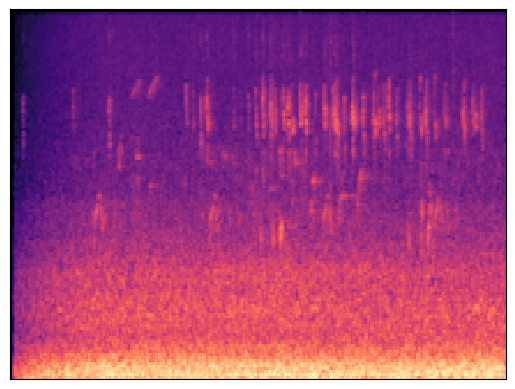

In [ ]:
print("shape:", next(iter(audio_image_store.values())).shape)
librosa.display.specshow(next(iter(audio_image_store.values()))[0])

In [19]:
birds_dataset = BirdClefDataset(audio_image_store, meta=meta, sr=SR, duration=DURATION, is_train=True)
print(len(birds_dataset))

x, y = birds_dataset[np.random.choice(len(birds_dataset))]
x.shape, y.shape

21289


((3, 128, 281), (152,))

### Training functions

In [20]:
def get_binary_entropy(numpy_arr):
  one_minus_arr = np.ones_like(numpy_arr) - numpy_arr
  return -(numpy_arr * np.log(numpy_arr) + one_minus_arr * np.log(one_minus_arr))

In [21]:
def one_step(x_batch, y_batch, model, criterion, optimizer, scheduler=None):
    x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

    # initiate optomizer
    optimizer.zero_grad()

    # input one batch to the model
    output = model(x_batch)
    loss_criterion = criterion(output, y_batch)
    loss_criterion.backward()
    optimizer.step()

    # calculate step metrics
    with torch.no_grad():
        loss = loss_criterion.item()

        output = output.sigmoid()
        y_batch = (y_batch > 0.5)*1.0
        lrap = label_ranking_average_precision_score(y_batch.cpu().numpy(), output.cpu().numpy())

        output = (output > 0.5)*1.0

        prec = (output*y_batch).sum()/(1e-6 + output.sum())
        rec = (output*y_batch).sum()/(1e-6 + y_batch.sum())
        f1 = 2*prec*rec/(1e-6+prec+rec)

    # adjust learning rate
    if scheduler is not None:
        scheduler.step()

    # loss, label_ranking_average_precision, f1, , precision
    return loss, lrap, f1.item(), rec.item(), prec.item()


# evaluate model on validation data and calculate validation metrics
@torch.no_grad()
def evaluate(model, criterion, val_laoder):
    model.eval()

    outs, y = [], []
    val_laoder = tqdm(val_laoder, leave = False, total=len(val_laoder))

    for icount, (x_batch, y_batch) in  enumerate(val_laoder):
        y.append(y_batch.to(DEVICE))
        x_batch = x_batch.to(DEVICE)
        output = model(x_batch)
        outs.append(output)

    y = torch.cat(y)
    output = torch.cat(outs)

    loss = criterion(output, y).item()

    output = output.sigmoid()
    y = (y > 0.5)*1.0

    lrap = label_ranking_average_precision_score(y.cpu().numpy(), output.cpu().numpy())

    output = (output > 0.5)*1.0

    prec = ((output*y).sum()/(1e-6 + output.sum())).item()
    rec = ((output*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)

    return loss, lrap, f1, rec, prec,


def one_epoch(model, criterion, optimizer, scheduler, train_loader, val_laoder):
    model.train()
    loss, lrap, prec, rec, f1, icount = 0., 0., 0., 0., 0., 0
    train_loader = tqdm(train_loader, leave = False) # train data iterator
    epoch_bar = train_loader

    # for each batch containing data and labels,
    # make one train step and get train metrics
    label_sums = torch.zeros(NUM_CLASSES)
    totals = torch.zeros(NUM_CLASSES)
    for (x_batch, y_batch) in epoch_bar:
        label_sums += torch.sum(y_batch, dim=0)
        totals += torch.ones(NUM_CLASSES) * y_batch.size()[0]
        _loss, _lrap, _f1, _rec, _prec = one_step(x_batch, y_batch, model, criterion, optimizer)
        loss += _loss
        lrap += _lrap
        f1 += _f1
        rec += _rec
        prec += _prec

        icount += 1

        # the set postfix will display the stats below on the end of the iteration
        # only if epoch_baris tqdm iterator
        if hasattr(epoch_bar, "set_postfix") and not icount%10:
            epoch_bar.set_postfix(
                loss="{:.6f}".format(loss/icount),
                lrap="{:.3f}".format(lrap/icount),
                prec="{:.3f}".format(prec/icount),
                rec="{:.3f}".format(rec/icount),
                f1="{:.3f}".format(f1/icount),
            )
    label_frequencies = (label_sums / totals).cpu().detach().numpy()
    label_entropies = get_binary_entropy(label_frequencies)
    average_entropy = np.mean(label_entropies).item()

    scheduler.step()

    loss /= icount
    lrap /= icount
    f1 /= icount
    rec /= icount
    prec /= icount

    # evaluate validation metrics
    loss_val, lrap_val, f1_val, rec_val, prec_val = evaluate(model, criterion, val_laoder)

    # return (train, val) metrics
    return (loss, loss_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val), average_entropy


def one_fold(fold, train_set, val_set, epochs=20, save=True, save_root=None):
    save_root = Path(save_root) or MODEL_ROOT
    saver = AutoSave(root=save_root, name=f"birdclef_2022_fold{fold}", metric="f1_val")
    model = load_model()

    # set model functions
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=8e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)

    # split train / val data - using DataLoader iterator over the batches
    train_data = BirdClefDataset(audio_image_store, meta=meta.iloc[train_set].reset_index(drop=True),
                                 sr=SR, duration=DURATION, is_train=True)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE,
                                               num_workers=TRAIN_NUM_WORKERS, shuffle=True,
                                               pin_memory=True)

    val_data = BirdClefDataset(audio_image_store, meta=meta.iloc[val_set].reset_index(drop=True),  sr=SR, duration=DURATION, is_train=False)
    val_laoder = torch.utils.data.DataLoader(val_data, batch_size=VAL_BATCH_SIZE,
                                             num_workers=VAL_NUM_WORKERS, shuffle=False)

    # for each epoch, train the model
    epochs_bar = tqdm(list(range(epochs)), leave=False)
    for epoch  in epochs_bar:
        epochs_bar.set_description(f"--> [EPOCH {epoch:02d}]")
        model.train()

        (loss, loss_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val), average_entropy = one_epoch(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            scheduler=scheduler,
            train_loader=train_loader,
            val_laoder=val_laoder,
        )

        # print statistics in the tqdm output
        epochs_bar.set_postfix(
            loss="({:.6f}, {:.6f})".format(loss, loss_val),
            prec="({:.3f}, {:.3f})".format(prec, prec_val),
            rec="({:.3f}, {:.3f})".format(rec, rec_val),
            f1="({:.3f}, {:.3f})".format(f1, f1_val),
            lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
            average_entropy="({:.3f})".format(average_entropy),
        )

        # print statistics after the iteration
        print(
            "[{epoch:02d}] loss: {loss} lrap: {lrap} f1: {f1} rec: {rec} prec: {prec}, average_entropy: {average_entropy}".format(
                epoch=epoch,
                loss="({:.6f}, {:.6f})".format(loss, loss_val),
                prec="({:.3f}, {:.3f})".format(prec, prec_val),
                rec="({:.3f}, {:.3f})".format(rec, rec_val),
                f1="({:.3f}, {:.3f})".format(f1, f1_val),
                lrap="({:.3f}, {:.3f})".format(lrap, lrap_val),
                average_entropy="({:.3f})".format(average_entropy),
            )
        )

        if save:
            metrics = {
                "loss": loss, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
                "loss_val": loss_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
                "epoch": epoch,
            }

            # log metrics and save model
            saver.log(model, metrics)


### Train the model

In [22]:
def train(epochs=20, save=True, n_splits=5, seed=177, save_root=None, suffix="", folds=None):
    gc.collect()
    torch.cuda.empty_cache()

    # save the model to save_root
    save_root = save_root or MODEL_ROOT/f"2022-{suffix}"
    save_root.mkdir(exist_ok=True, parents=True)

    # group data by fold index
    fold_bar = tqdm(meta.reset_index().groupby("fold").index.apply(list).items(), total=meta.fold.max()+1)

    # for each fold, train separatly
    for fold, val_set in fold_bar:
        if folds and not fold in folds:
            continue

        print(f"\n############################### [FOLD {fold}]")
        fold_bar.set_description(f"[FOLD {fold}]")
        train_set = np.setdiff1d(meta.index, val_set)

        # train one fold
        one_fold(fold=fold, train_set=train_set , val_set=val_set , epochs=epochs, save=save, save_root=save_root)

        gc.collect()
        torch.cuda.empty_cache()

In [ ]:
try:
    # folds - the fold index for validation. rest are used for training
    train(epochs=8, suffix=f"_sr{SR}_d7mels_mixup_rate2_v1", folds=[0, 1, 2, 3, 4])
except Exception as e:
    raise ValueError() from  e